In [3]:
import os, dotenv

dotenv.load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["COMPOSIO_API_KEY"] = os.getenv("COMPOSIO_API_KEY")

In [6]:
## Models
from langchain_google_genai import  ChatGoogleGenerativeAI
from langchain_groq import  ChatGroq

gemini_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
llama_model = ChatGroq(model="llama-3.3-70b-versatile")
deepseek_model = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [82]:
from typing_extensions import TypedDict
from typing import Annotated, Literal

from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages

## State
class LinkedInGraphState(MessagesState):
    task: str
    critique: str
    post: str
    user_feedback: str
    llm_feedback: str
    context: list


In [83]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.types import Command

tavily_tool = TavilySearchResults(max_results=5)

def web_search(state: LinkedInGraphState) -> Command[Literal["post_writer"]]:
    # results = tavily_tool.invoke(state['messages'])

    return Command(
        # state update
        update={"context": "results"},
        goto="post_writer"
    )

In [84]:
def post_writer(state: LinkedInGraphState)-> Command[Literal["critique_generator"]]:
    
    return Command(
        update={"post": state['messages'][-1]},
        goto="critique_generator"
    )

In [85]:
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, AIMessage, ToolMessage, HumanMessage, AnyMessage

class PostAnalystSchema(BaseModel):
    next_node: Literal["post_writer", "upload_post"]
    feedback: str = Field(description="The feedback about the post.")

post_analyst_llm = llama_model.with_structured_output(PostAnalystSchema)

CRITIQUE_PROMPT = """You are a LinkedIn post analyst. Your task is to route the given post to either back to the post_writer or to upload_post nodes. 
If the given post is well-written according to the given example posts, route it upload_post node, so that it can be posted on LinkedIn.
If the post does not match the style of given example posts, route it back to the post_writer node along with the feedback so that it can improve
the post.

## Example Posts:

#### Example 1:
Software engineers who do not speak well 

or do not dress presentable will struggle.

If your MO is I am great technical talent and thats all that matters. 

Neglect the effort to communicate better or make an impression to stakeholders.

When Ai catches up to become a principal engineer, your worth diminishes.

Get good at talking to people, care about how you present your ideas and yourself.

Will make such a difference.
Agree?
---

#### Example 2:
CS STUDENTS: Snapchat is paying entry-level engineers in nyc $190k.

Snap isn’t paying $190k to test their “ar googles.”

Snap is paying $190k or even $500k so you can be part of the team that can help them make their next $100Bn in market cap.

Too many “talent” and potentially even “motivated” young engineers get all “hip hip hooray” after landing the TC (offer letter)…

without visualizing the bigger picture. Why do you exist? What does your team and director do? Which team/product line makes the most money? How do you make the company better?

Someone can argue if the purpose of your specific role as an engineer is opaque and the intrigue to better your technical organization is missing…

there might be diminishing returns on hiring such an engineer in the advent of ai. 

Thoughts?
---

#### Example 3:
NYC Hacker house meetup. 

This was how it went down.

1/ gather at the hacker house
2/ eat and vibe
3/ go to the office 

7 headstarter residents and mentor(google) and hiring manager at startup ($145mn series A) came. 

I gave folks a game plan on how to get a job, roasted resumes and everyone just vibes.

IRL is where its at. 

Who agrees? 

Run it back again?
"""

def post_analyzer(state: LinkedInGraphState) -> Command[Literal["upload_post", "post_writer"]]:
    
    post_analysis = post_analyst_llm.invoke([SystemMessage(content=CRITIQUE_PROMPT)] + [state["post"]])

    if post_analysis.next_node == "post_writer":
        goto = "post_writer"
    elif post_analysis.next_node == "upload_post":
        goto = "upload_post"

    return Command(
        update={"llm_feedback": post_analysis.feedback},
        goto=goto
    )

In [86]:
def upload_post(state: LinkedInGraphState) -> Command[Literal["__end__"]]:
    
    return Command(
        update={"messages": [HumanMessage(content="The post has successfully been posted!")]},
        goto="__end__"
    )
    

In [88]:
def task_router(state: LinkedInGraphState) -> Literal["post_writer", "web_search"]:
    if state.get("feedback"):
        return "post_writer"
    return "web_search"

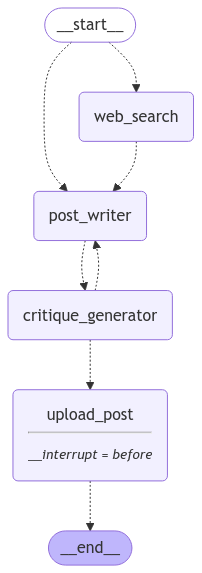

In [89]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Annotated
from IPython.display import Image, display

# Build graph
builder = StateGraph(LinkedInGraphState)

builder.add_node("post_writer", post_writer)
builder.add_node("web_search", web_search)
builder.add_node("post_analyzer", post_analyzer)
builder.add_node("upload_post", upload_post)

builder.add_conditional_edges(START, task_router)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer, interrupt_before=["upload_post"])

## Display graph
display(Image(graph.get_graph().draw_mermaid_png()))


In [90]:
config = {"configurable": {"thread_id": "1"}}

for m in graph.stream({"messages": [HumanMessage(content="""In Case You Didn’t Peep: Chinese AI Startup DeepSeek Triggers $1 Trillion Tech Sell-Off — NVIDIA On Track For Biggest Decline In Stock History 🤯

DeepSeek’s latest open-source AI model, R1, has led to many questioning the need for the billions being spent on chips and other AI infrastructure.

Put simply, DeepSeek shows that AI models can run on less advanced chip, at 1/30th of the cost (reportedly $5M) and perform just as well, if not better.

Looks like Jensen’s leather jackets wont be the be-all and end-all in this one ☝️ 

Thoughts?""")]}, config=config):
    print(m)

{'web_search': {'context': 'results'}}
{'post_writer': {'post': HumanMessage(content='In Case You Didn’t Peep: Chinese AI Startup DeepSeek Triggers $1 Trillion Tech Sell-Off — NVIDIA On Track For Biggest Decline In Stock History 🤯\n\nDeepSeek’s latest open-source AI model, R1, has led to many questioning the need for the billions being spent on chips and other AI infrastructure.\n\nPut simply, DeepSeek shows that AI models can run on less advanced chip, at 1/30th of the cost (reportedly $5M) and perform just as well, if not better.\n\nLooks like Jensen’s leather jackets wont be the be-all and end-all in this one ☝️ \n\nThoughts?', additional_kwargs={}, response_metadata={}, id='53e8f762-8b69-4bdd-bcfe-3a202bb7c8f3')}}
{'critique_generator': {'llm_feedback': 'The post is well-written and matches the style of the given example posts. It is engaging, informative, and ends with a thought-provoking question.'}}
{'__interrupt__': ()}


In [91]:
for m in graph.stream(None, config=config):
    print(m)

{'upload_post': {'messages': [HumanMessage(content='The post has successfully been posted!', additional_kwargs={}, response_metadata={}, id='c7175b8c-c661-4a47-8a7c-987d35be7da6')]}}
